In [23]:
import sqlalchemy as sa
from dotenv import load_dotenv
import pandas as pd
import os
import numpy as np


load_dotenv()

conn_string = 'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/cosmetic'.format(
    db_user=os.getenv('DB_USER'),
    db_password=os.getenv('DB_PASSWORD'),
    db_host=os.getenv('DB_HOST'),
    db_port=os.getenv('DB_PORT'),
)
engine = sa.create_engine(conn_string)

In [6]:
# read CSV datasource
raw_df = pd.concat([
    pd.read_csv('../.data/cosmetic/2019-10.csv'),
    pd.read_csv('../.data/cosmetic/2019-11.csv'),
    pd.read_csv('../.data/cosmetic/2019-12.csv'),
    pd.read_csv('../.data/cosmetic/2020-01.csv'),
    pd.read_csv('../.data/cosmetic/2020-02.csv'),
])

print('Count:', raw_df.shape[0])
raw_df.head(15)

Count: 20692840


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
5,2019-10-01 00:00:16 UTC,cart,5857269,1487580005134238553,NaN,runail,2.62,430174032,73dea1e7-664e-43f4-8b30-d32b9d5af04f
6,2019-10-01 00:00:19 UTC,cart,5739055,1487580008246412266,NaN,kapous,4.75,377667011,81326ac6-daa4-4f0a-b488-fd0956a78733
7,2019-10-01 00:00:24 UTC,cart,5825598,1487580009445982239,NaN,NaN,0.56,467916806,2f5b5546-b8cb-9ee7-7ecd-84276f8ef486
8,2019-10-01 00:00:25 UTC,cart,5698989,1487580006317032337,NaN,NaN,1.27,385985999,d30965e8-1101-44ab-b45d-cc1bb9fae694
9,2019-10-01 00:00:26 UTC,view,5875317,2029082628195353599,NaN,NaN,1.59,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe


In [5]:
# insert SQL database
with engine.connect() as conn:
    conn.execute(sa.text('TRUNCATE TABLE events'))

    raw_df.to_sql(
        name='events', 
        con=conn, 
        if_exists='append', 
        index=False, 
        chunksize=1000,
        dtype={
            'event_time': sa.types.TIMESTAMP(timezone=True),
            'event_type': sa.types.Enum('view', 'cart', 'remove_from_cart', 'purchase', name="EVENT_TYPE"),
        }
    )

    conn.commit()

In [36]:
# memorize products' release date and max price
with engine.connect() as conn:
    product_df = pd.read_sql('''
            SELECT 
                e.product_id,
                e.category_id,
                MIN(e.event_time)::DATE as release_date,
                MAX(e.price) as max_price,
                COUNT(*) AS events_count
            FROM 
                events e
            GROUP BY
                e.product_id, e.category_id
            ORDER BY
                e.category_id ASC,
                e.product_id ASC
        ''',
        con=conn
    )

    conn.execute(sa.text('TRUNCATE TABLE products'))

    product_df.to_sql(
        name='products', 
        con=conn, 
        if_exists='append', 
        index=False,
        chunksize=1000,
        dtype={
            'release_date': sa.types.DATE
        }
    )

    conn.commit()

print('Count:', product_df.shape[0])
product_df

Count: 56190


,product_id,category_id,release_date,max_price,events_count
0,5916194,1487580004807082827,2019-12-25,11.70,37
1,5916195,1487580004807082827,2019-12-25,12.41,74
2,5706112,1487580004832248652,2019-10-09,14.13,6
3,5706113,1487580004832248652,2019-10-01,15.08,361
4,5706114,1487580004832248652,2019-10-01,14.13,261
...,...,...,...,...,...
56185,5929661,2242903426784559183,2020-02-17,9.52,9
56186,5929662,2242903426784559183,2020-02-17,9.52,30
56187,5929663,2242903426784559183,2020-02-17,7.94,13
56188,5929671,2242903426784559183,2020-02-17,8.73,11


In [3]:
# clip outliers. NOTE: after fetching products' information
with engine.connect() as conn:
    conn.execute(sa.text('''
        UPDATE events e
        SET price = p.max_price
        FROM products p
        WHERE
            e.product_id = p.product_id
            AND e.category_id = p.category_id
            AND e.price = 0
    '''))

    conn.commit()


In [32]:
# Percentile
with engine.connect() as conn:
    distribution = pd.read_sql(
        '''
            SELECT COUNT(*) as cnt
            FROM events e
            GROUP BY e.category_id, e.product_id
        ''',
        con=conn
    )

arr = distribution['cnt'].values
threshold = np.percentile(arr, 50)
threshold

107.0

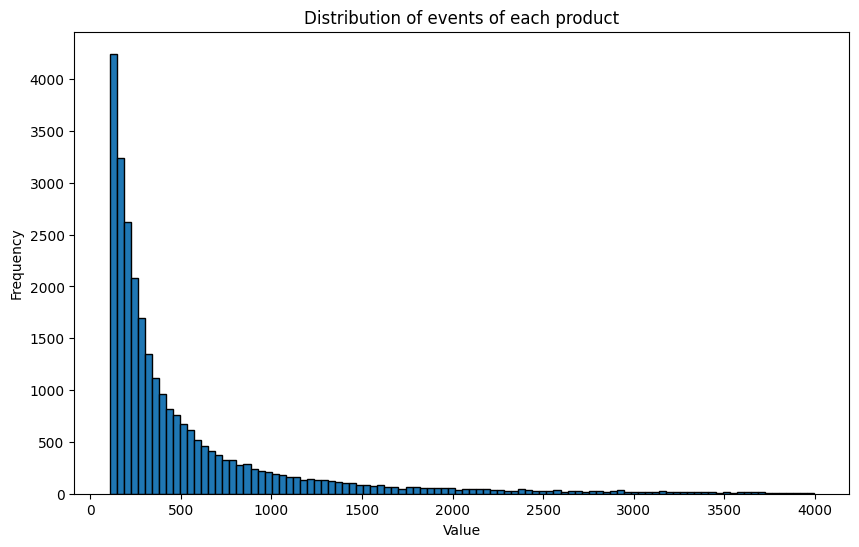

In [34]:
# Events count of products distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(arr[(arr >= 107) & (arr < 4_000)], bins=100, edgecolor='black')  # You can adjust the number of bins

# Adding titles and labels
plt.title('Distribution of events of each product')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()